**CONTENT**

In this notebook we will create stochastic simulations based on either `COVID19_SEIRD_sto` or `COVID19_SEIRD_sto_spatial` with various *initial conditions* and *imposed measures*.

**OPEN TASKS**

*short term*
1. ~~Define some interesting realistic and/or artificial initial conditions~~
2. Define some interesting realistic and/or artificial imposed measures
3. Initiate the models and create a readable environment to make nice plots (create some definitions?)
4. Compare the dynamics and results of the spatially stratified model with the national model (these should largely correspond with each other)
5. Choose the most pertinent conditions and measures for plotting in geopandas and make a full-resolution video of the simulation
6. ~~Plot infections, hospitalisations and deaths~~
7. *Important*: Compare with actual data
8. Automate the hard-code in `models.py` line `coordinates = [read_coordinates_nis(spatial='test')]`
9. Find a nice way to show upper and lower percentiles

*long term*  
1. Implement the functions in the `utils.py` environment
2. Take out the most relevant results and summarise in a $\LaTeX$ presentation
3. Include age-stratification for the mobility matrix $P^{gh}$
4. Include spatial stratification for the mobility parameter $p_i$: simulate negative travel advice
5. Include age stratification for *all* hospital parameters (including average number of days in the hospital)
6. Visualise the measures
7. Include framework for vaccination
8. Allow for fractional infection from mildly symptomatic people that ignore safety regulations (self-isolation), preferably based on research
9. Show age distribution in the relevant time series at any time

**OPEN QUESTIONS**

1. What is the reason for and the meaning of the normalisation factor $z_i$ in `COVID19_SEIRD_sto_spatial`?
2. Is it OK for all susceptibility factors $s_i$ to be smaller than one, as is the case now?
3. Can we simulate home isolation within this framework? If the contact matrix $N_{c,ij}$ is set to only $N_{home,ij}$, this still assumes homogeneity within each patch. One than still has contact with the entire patch, which is not realistic
4. Only professional commuting is included, but presumably this is not sufficient. Can we use these simulations to verify that?
5. Why are there so few hospitalisations compared to the number of deaths? This seems odd

# Load packages

In [11]:
# This is copied from 0.1-mrollier-spatial-stochastic
# Not all packages may be needed

import random
import os
import numpy as np
import json
import corner # make beautiful corner plots for demonstrating the parameter distributions
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib
import matplotlib.colors as colors
import matplotlib.dates as mdates # sophisticated date plotting capabilities
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import emcee # Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (**MCMC**) Ensemble sampler
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import name2nis, read_coordinates_nis, read_areas, read_pops, dens_dep, MC_sim, draw_sample_COVID19_SEIRD # New function that translates names to NIS codes
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Geopandas shapefiles
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics

# Load different geographical aggregations
maps_dir = '../data/raw/geopandas/BE/'

country = gp.read_file(os.path.join(maps_dir, 'AD_6_Country.shp'))
regions = gp.read_file(os.path.join(maps_dir, 'AD_5_Region.shp'))
provinces = gp.read_file(os.path.join(maps_dir, 'AD_4_Province.shp'))
arrondissements = gp.read_file(os.path.join(maps_dir, 'AD_3_District.shp'))
municipalities = gp.read_file(os.path.join(maps_dir, 'AD_2_Municipality.shp'))
testgeo = arrondissements.loc[arrondissements['NISCode'].isin(['11000', '21000', '44000'])].reset_index(drop=True)

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Initialisation of the model

## Oversight of various model conditions

Any of the conditions below are implemented for both the spatial and the national stochastic SEIRD-extended model.

**Initial conditions**
1. One exposed person on day 0. With some spatial variation:  
    1. On the far southeast side of the country  
    2. On the far northwest side of the country  
    3. In Brussels  
2. Fifty exposed people on day 0, same spatial variation
3. Only asymptomatic people instead of exposed people
4. Only presymptomatic people instead of exposed people
5. No mobility whatsoever (sanity check, can only be done in spatial model)

**Measures**
1. Decrease overall contact parameter: type of contact stays the same, but the frequency is lowered
2. Change *type* of contact: only remain home contact (but note that this does not mean that families are isolated!)
3. Decrease mobility between cities (can only be done in spatial model)
4. Vaccination: migrate the number of Susceptible straight to the Recovered category

**Spatial levels**
1. 'Test' level: only arrondissements Antwerpen, Brussel, Gent
2. Arrondissement level: 43 arrondissements
3. Province level: 10+1 provinces
4. National level: no spatial stratification

## Initialisation definition

In [6]:
#################
# CONTROL PANEL #
#################

# ---------------------------- #
# Choose stratification levels #
# ---------------------------- #

age_str = True
spatial_str = 'test' # Choice between test, arr, prov or None.
# Note: changing spatial_str in general means I also have to go in the models.py code
# and change "coordinates = [read_coordinates_nis(spatial='test')]"

# ------------------------ #
# Choose initial infectors #
# ------------------------ #

init_type = 'E' # Choice between E, I or A
init_number = 50
init_place = 1 # ordered per NIS number
init_age = 3 # must be 0 if age_str = False

# ------------------------------------------ #
# Choose initial mobility and contact values #
# ------------------------------------------ #

intensity = 'all' # Choice between 'all', 'physical_only', 'less_5_min', 'more_5_min', less_15_min',
                    # 'more_15_min', 'more_one_hour', 'more_four_hours'
pi = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1.]) # pi = np.array([1.])

# ---------------------------- #
# Choose simulation parameters #
# ---------------------------- #

sim_number = 10
days_number = 100

# ------------------------------ #
# Define social inertia function #
# ------------------------------ #

# Delayed ramp 2
def social_policy_func(t,param,policy_time,policy1,policy2,ll,tau):
    if t < policy_time:
        return policy1
    else:
        tt = t-policy_time
        if tt <= tau:
            return policy1
        if (tt > tau) & (tt <= tau + ll):
            intermediate = (policy2 - policy1) / ll * (tt - tau) + policy1
            return intermediate
        if tt > tau + ll:
            return policy2

# Parameter values
ll = 5
tau = 5

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number

#################
# CONTROL PANEL #
#################

In [7]:
# Fetch model parameters
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

print(initN)

# Include additional parameters
params.update({'ll': ll,
              'tau': tau})

# Define nature of measures
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': policy_time})

# Update mobility parameter
params.update({'pi': pi})

# Define initial demography
N = len(params['Nc'])
G = 1
if spatial_str:
    G = len(params['place'][0])

if age_str==False:
    initN_dummy = np.zeros([G,N])
    for g in range(G):
        initN_dummy[g,0] = initN.sum(axis=1)[g]
    initN = initN_dummy
    
# Set initial states
E = np.zeros([G,N])
I = np.zeros([G,N])
A = np.zeros([G,N])
pop_dict = dict({'E' : E, 'I' : I, 'A' : A})

# Set initial infectors
pop_dict[init_type][init_place,init_age] = init_number
init_states = {'S': initN, init_type : pop_dict[init_type]}

# Load the model
if spatial_str:
    model = models.COVID19_SEIRD_sto_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)
else:
    model = models.COVID19_SEIRD_sto(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)

[[125595 118460 133119 142794 132880 140311 118454  83733  62390]
 [163741 140462 181940 200083 173777 142874 100741  65453  49184]
 [ 59684  59524  76628  78501  73806  75007  62096  44568  34228]]


In [13]:
draw_sample_COVID19_SEIRD(model, dict({'beta' : [0.05, 0.04, 0.03], 'l' : [5, 4, 3], 'tau' : [3, 4, 5]}))

In [603]:
# Make a dictionary of time series of infections, hospitalisations and deaths for each simulation

# Single model to fetch NIS numbers and time list
out = model.sim(days_number)
NISlist = out['place'].values
tlist = out['time'].values

# Initialise empty list of time series for every simulation and make into dictionary
# Resulting dictionary is structured as ts_dict[nis][timeseries][simulation][time]
ts_dict = dict({})
ts_list = ['E', 'H_in', 'D']
for nis in NISlist:
    ts_dict[nis] = dict({})
    for ts in ts_list:
        ts_dict[nis][ts] = np.zeros([sim_number, days_number+1])
    
for i in range(sim_number):
    print(f'Executing simulation number {i+1}/{sim_number}     \r', end="")
    out = model.sim(days_number)
    for nis in NISlist:
        for ts in ts_list:
            # Sum all age categories
            values = out[ts].sel(place=nis).sum(dim='Nc')#.values
            ts_dict[nis][ts][i] = values

In [598]:
# test_array = out['E'].sel(place=21000).sum(dim='Nc')
# newdim = dict({'iteration' : np.arange(0,sim_number,1)})
# out.expand_dims(dim=newdim)
# out['E'].expand_dims(dim=newdim).sel(iteration=40)
# out['E']

<xarray.DataArray 'E' (place: 3, Nc: 9, time: 101)>
array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 2., 1.],
        [0., 0., 0., ..., 6., 3., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.]],

       [[0., 0., 0., ..., 2., 2., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * place    (place) int64 11000 21000 44000
  * Nc       (Nc) int32 0 1 2 3 4 5 6 7 8

# Plotting

## Plotting in graph

Saved figure test_11000_500simulations_symlog.jpg                    


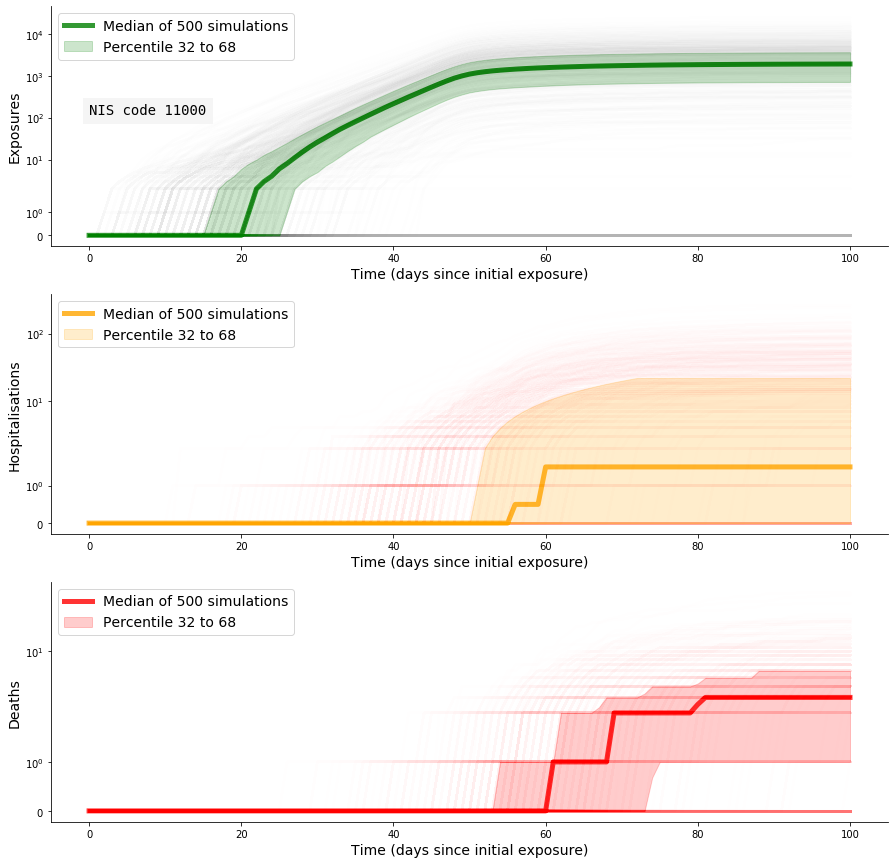

In [607]:
# Plot the results in a graph

savefig = True
dpi=100
text_size = 14
yscale = 'symlog' # symlog or linear
cumsum = True
nis = 11000
alpha=1/sim_number
figname = spatial_str + '_' + str(nis) + '_' + str(sim_number) + 'simulations_' + yscale + '.jpg'

upper_pct = 68
lower_pct = 100 - upper_pct

# Initiate figure environment

fig1, (f1_ax1, f1_ax2, f1_ax3) = plt.subplots(3, 1, figsize=(15,15))
f1_ax_dict = dict({'E' : f1_ax1, 'H_in' : f1_ax2, 'D' : f1_ax3})
color_dict = dict({'E' : 'g', 'H_in' : 'orange', 'D' : 'red'})
for ax in [f1_ax1, f1_ax2, f1_ax3]:
    ax.grid(False)
    ax.set_yscale(yscale)
    ax.set_xlabel('Time (days since initial exposure)', size=text_size)
f1_ax1.set_ylabel('Exposures', size=text_size)
f1_ax2.set_ylabel('Hospitalisations', size=text_size)
f1_ax3.set_ylabel('Deaths', size=text_size)

plt.figtext(0.16, .78, 'NIS code ' + str(nis), backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)


for ts in ts_list:
    
    time_max = np.unravel_index(np.argmax(ts_dict[nis][ts]), ts_dict[nis][ts].shape)[1]
    
    # Initialise percentile time series
    ts_lower = np.zeros(len(tlist))
    ts_upper = np.zeros(len(tlist))
    ts_median = np.zeros(len(tlist))
    for t in tlist:
        upper = np.percentile(ts_dict[nis][ts].T[t], upper_pct)
        lower = np.percentile(ts_dict[nis][ts].T[t], lower_pct)
        median = np.percentile(ts_dict[nis][ts].T[t], 50)
        ts_lower[t] = lower
        ts_upper[t] = upper
        ts_median[t] = median
    
    if cumsum & (ts != 'D'):
        # Perhaps of interest if we want the mean, but this is typically much lower than the median
        ts_mean = ts_dict[nis][ts].mean(axis=0).cumsum()
        ts_lower = ts_lower.cumsum()
        ts_upper = ts_upper.cumsum()
        ts_median = ts_median.cumsum()
    else:
        # Perhaps of interest if we want the mean, but this is typically much lower than the median
        ts_mean = ts_dict[nis][ts].mean(axis=0)
    ax = f1_ax_dict[ts]
#     label = 'Mean of ' + str(sim_number) + ' simulations'
    label1 = 'Median of ' + str(sim_number) + ' simulations'
    label2 = 'Percentile ' + str(lower_pct) + ' to ' + str(upper_pct)
    ax.plot(tlist, ts_median, color=color_dict[ts], alpha=0.8, linewidth=5, label=label1)
    ax.fill_between(tlist, ts_lower, ts_upper, color=color_dict[ts], alpha=0.2, label=label2)
    ax.legend(loc=2,prop={'size': text_size})
    for i in range(sim_number):
        print(f'Plotting simulation number {i+1}/{sim_number} for timeseries {ts}     \r', end="")
        if cumsum & (ts != 'D'):
            ax.plot(tlist, ts_dict[nis][ts][i].cumsum(), color=color_dict[ts], alpha=alpha)
        else:
            ax.plot(tlist, ts_dict[nis][ts][i], color=color_dict[ts], alpha=alpha)
            
if savefig:
    # Save figure
    plt.savefig(figname, dpi=dpi, bbox_inches='tight')
    print('Saved figure ' + figname + ' '*20)

In [614]:
# This doesn't say anything cause because the dimension is time. The dimension should be model iterations

out.quantile([0.05, 0.95], dim='time', interpolation='linear')['E'].sel(quantile=0.95)

<xarray.DataArray 'E' (place: 3, Nc: 9)>
array([[ 11.,  11.,  32.,  42.,  44.,  26.,  19.,   8.,   7.],
       [ 30.,  33., 102., 112.,  97.,  93.,  37.,  28.,  22.],
       [  5.,   5.,  10.,  15.,  12.,  14.,   7.,   5.,   4.]])
Coordinates:
  * place     (place) int64 11000 21000 44000
  * Nc        (Nc) int32 0 1 2 3 4 5 6 7 8
    quantile  float64 0.95

## Plotting in Geopandas

### Geopandas-and-plots for test case

In [622]:
# Use gridspec for nicely ordered plotting
import matplotlib.gridspec as gridspec

# Choose the results that are plotted on the map
ts_geo = 'E' # either 'E', 'H_in' or 'D'

# Plot the results
savefig = True
dpi=100
text_size = 14
yscale_geo = 'symlog' # symlog or linear
yscale_graph = 'linear' # symlog or linear
cumsum = True
alpha=0.01
figname = spatial_str + '_geopandas-and-time-series_simulation'

plot_alpha = False

color_dict = dict({11000 : 'tomato', 21000 : 'dodgerblue', 44000 : 'limegreen'})
cmap = 'Oranges'

# Initialise new column in geopandas dataframe
testgeo.loc[:,ts_geo] = 0
ylabel_pos = (-0.12,0.5)

# Set minima/maxima dictionary
vmax = dict({'E' : [ts_dict[nis]['E'].max() for nis in NISlist],
            'H_in' : [ts_dict[nis]['H_in'].max() for nis in NISlist],
            'D' : [ts_dict[nis]['D'].max() for nis in NISlist]})
vmin = 0

graphmax = dict({})
for ts in ts_list:
    if cumsum & (ts != 'D'):
        graphmax[ts] = max([ts_dict[nis][ts].mean(axis=0).cumsum()[-1] for nis in NISlist])
    else:
        graphmax[ts] = max([ts_dict[nis][ts].mean(axis=0).max() for nis in NISlist])

for t in tlist:
    print(f'Working on day {t+1}/{tlist[-1]}\r', end="")

    fig2 = plt.figure(figsize=(15,7))
    gs = fig2.add_gridspec(3, 2, width_ratios=[3,2])

    f2_ax0 = fig2.add_subplot(gs[:, 0])
    f2_ax0.set_axis_off()
    cax = make_axes_locatable(f2_ax0).append_axes("left", size="5%", pad=1) # Legend properties

    f2_ax1 = fig2.add_subplot(gs[0,1])
    f2_ax1.set_ylabel('Exposed', size=text_size)
    f2_ax1.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax2 = fig2.add_subplot(gs[1,1])
    f2_ax2.set_ylabel('Hospitalised', size=text_size)
    f2_ax2.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax3 = fig2.add_subplot(gs[2,1])
    f2_ax3.set_ylabel('Dead', size=text_size)
    f2_ax3.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax_dict = dict({'E' : f2_ax1, 'H_in' : f2_ax2, 'D' : f2_ax3})
    
    for ax in [f2_ax1, f2_ax2, f2_ax3]:
        ax.set_yscale(yscale_graph)
        ax.grid(False)
    f2_ax3.set_xlabel('time (days since initial exposure)',size=text_size)
    
    
    
    # Plot geopandas
    for nis in NISlist:
        daily_value = ts_dict[nis][ts_geo].mean(axis=0)[t]
        testgeo.loc[testgeo['NISCode']==str(nis), ts_geo] = daily_value
        if yscale_geo == 'symlog':
            testgeo.plot(column=ts_geo, ax=f2_ax0, cmap=cmap,legend=True, edgecolor = 'k',
                     norm=colors.SymLogNorm(linthresh=1, vmin=0, vmax=graphmax[ts_geo]), cax=cax, alpha=1)
        if yscale_geo == 'linear':
            testgeo.plot(column=ts_geo, ax=f2_ax0, cmap=cmap,legend=True, edgecolor = 'k',
                     vmin=0, vmax=graphmax[ts_geo], cax=cax, alpha=1)
    
        # Plot graph
        for ts in ts_list:
            if cumsum & (ts != 'D'):
                ts_mean = ts_dict[nis][ts].mean(axis=0).cumsum()
            else:
                ts_mean = ts_dict[nis][ts].mean(axis=0)
            ax = f2_ax_dict[ts]
            label = 'Mean of ' + str(sim_number) + ' simulations'
            ax.plot(tlist, ts_mean, color=color_dict[nis], alpha=1, linewidth=2)
            if yscale_graph == 'symlog':
                ax.set_ylim([0,10*graphmax[ts]])
            else:
                ax.set_ylim([0,1.25*graphmax[ts]])
            
            if plot_alpha:
                for i in range(sim_number):
    #                 print(f'Plotting simulation number {i+1}/{sim_number} for timeseries {ts}     \r', end="")
                    if cumsum & (ts != 'D'):
                        ax.plot(tlist, ts_dict[nis][ts][i].cumsum(), color=color_dict[nis], alpha=alpha)
                    else:
                        ax.plot(tlist, ts_dict[nis][ts][i], color=color_dict[nis], alpha=alpha)
    for ax in [f2_ax1, f2_ax2, f2_ax3]:
        ax.axvline(t, color='r', linewidth=2, linestyle='--')
        
    # Add metadata
    plt.figtext(.29, .10, 'New exposures per day', backgroundcolor='whitesmoke', fontsize=14)
    plt.figtext(.37, .72, 'Antwerpen', backgroundcolor=color_dict[11000], fontsize=12)
    plt.figtext(.48, .28, 'Brussel', backgroundcolor=color_dict[21000], fontsize=12)
    plt.figtext(.20, .42, 'Gent', backgroundcolor=color_dict[44000], fontsize=12)
        
    if savefig:
        # Save figure
        savename = figname + str(t) + '.jpg'
        plt.savefig(savename, dpi=dpi, bbox_inches='tight')
        print('Saved figure ' + savename + ' '*20)
        
    plt.close('all')

Saved figure test_geopandas-and-time-series_simulation0.jpg                    
Saved figure test_geopandas-and-time-series_simulation1.jpg                    
Saved figure test_geopandas-and-time-series_simulation2.jpg                    
Saved figure test_geopandas-and-time-series_simulation3.jpg                    
Saved figure test_geopandas-and-time-series_simulation4.jpg                    
Saved figure test_geopandas-and-time-series_simulation5.jpg                    
Saved figure test_geopandas-and-time-series_simulation6.jpg                    
Saved figure test_geopandas-and-time-series_simulation7.jpg                    
Saved figure test_geopandas-and-time-series_simulation8.jpg                    
Saved figure test_geopandas-and-time-series_simulation9.jpg                    
Saved figure test_geopandas-and-time-series_simulation10.jpg                    
Saved figure test_geopandas-and-time-series_simulation11.jpg                    
Saved figure test_geopandas-and-time-s

In [ ]:
for t in tlist:
    print('Working on day {t}/{tlist[-1]}\r', end="")
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    cax = make_axes_locatable(ax1).append_axes("left", size="5%", pad=1) # Legend properties
    ax1.set_axis_off()
    ax2.grid(False)
#     ax2.set_yscale('symlog')
    
    for key in Edict:
        test.loc[test['NISCode']==str(key), 'E'] = Edict[key][t]

    fig = test.plot(column='E', ax=ax1, cmap='Reds',
             legend=True, edgecolor = 'k', norm=colors.LogNorm(vmin=vmin, vmax=vmax), cax=cax, alpha=1)

    ax2.plot(tlist,E0,label='Antwerpen',color='r')
    ax2.plot(tlist,E1,label='Brussel-Hoofdstad',color='g')
    ax2.plot(tlist,E2,label='Gent',color='b')
    ax2.axvline(t, color='r', linewidth=2, linestyle='--')
    ax2.legend()
    
    # Save figure
    chart = fig.get_figure()
    figname = 'Spatial-simulation_H-in_20-30yo-21000_test' + str(t) + '.jpg'
    chart.savefig(figname, dpi=dpi, bbox_inches='tight')
    print('Saved figure ' + figname)
    
    plt.close('all')